In [1]:
import datetime
from IPython.core.display import display, HTML
import math
import os
import pandas as pd
import random

import mlos.global_values as global_values
from mlos.Logger import create_logger
from mlos.Optimizers.BayesianOptimizerFactory import BayesianOptimizerFactory
from mlos.Optimizers.BayesianOptimizerConfigStore import bayesian_optimizer_config_store
from mlos.Optimizers.OptimizationProblem import OptimizationProblem, Objective
from mlos.Spaces import ContinuousDimension, Point, SimpleHypergrid
from mlos.Tracer import Tracer

display(HTML("<style>.container { width:100% !important; }</style>"))

global_values.declare_singletons()
global_values.tracer = Tracer(actor_id="MetaOptimizer", thread_id=0)

# Let's prepare a directory for our results.
#
optimizer_results_root_dir = r"E:\Mlos\OptimizerOptimization"
optimizer_results_folder_name = f"optimization_started_on_{datetime.datetime.now().strftime('%Y_%m_%d_at_%H_%M_%S')}"
optimizer_results_dir = os.path.abspath(os.path.join(optimizer_results_root_dir, optimizer_results_folder_name))
evaluation_reports_dir = os.path.abspath(os.path.join(optimizer_results_dir, "evaluation_reports"))
os.mkdir(optimizer_results_dir)
os.mkdir(evaluation_reports_dir)

# Let's stand up the Optimizer Microservice
#
optimizer_factory = BayesianOptimizerFactory()

In [2]:
os.getpid()

8184

In [3]:
# Let's make a meta optimizer.
#
meta_optimizer_config = bayesian_optimizer_config_store.default # get_config_by_name("default_with_glow_worm")
meta_optimizer_config.homogeneous_random_forest_regression_model_config.n_estimators = 50
meta_optimizer_config.homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.n_new_samples_before_refit = 5
meta_optimizer_config.experiment_designer_config.fraction_random_suggestions = 0.5
meta_optimizer_config.experiment_designer_config.random_search_optimizer_config.num_samples_per_iteration = 10000

num_inner_optimizer_iterations = 20
meta_optimizer_objective_name = f"optimum_value_after_{num_inner_optimizer_iterations}_iterations"

meta_optimizer = optimizer_factory.create_local_optimizer(
    optimizer_config=meta_optimizer_config,
    optimization_problem=OptimizationProblem(
        parameter_space=bayesian_optimizer_config_store.parameter_space,
        objective_space=SimpleHypergrid(
            name="predictions",
            dimensions=[
                ContinuousDimension(name=meta_optimizer_objective_name, min=-math.inf, max=math.inf)
            ]
        ),
        objectives=[Objective(name=meta_optimizer_objective_name, minimize=True)]
    )
)

10/07/2020 18:04:36 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 50,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

In [4]:
from mlos.OptimizerEvaluationTools.ObjectiveFunctionFactory import ObjectiveFunctionFactory
from mlos.OptimizerEvaluationTools.ObjectiveFunctionConfigStore import objective_function_config_store

objective_function_config = objective_function_config_store.get_config_by_name('5_mutually_exclusive_polynomials')
objective_function_config.nested_polynomial_objective_config.polynomial_objective_config.input_domain_min = -20
objective_function_config.nested_polynomial_objective_config.polynomial_objective_config.input_domain_width = 40
objective_function_config.nested_polynomial_objective_config.polynomial_objective_config.coefficient_domain_min = 100
objective_function_config.nested_polynomial_objective_config.polynomial_objective_config.coefficient_domain_width = 10
objective_function_config.nested_polynomial_objective_config.polynomial_objective_config.include_noise = False
objective_function_config.nested_polynomial_objective_config.polynomial_objective_config.noice_coefficient_of_variation = 0.0
print(objective_function_config.to_json(indent=2))

objective_function = ObjectiveFunctionFactory.create_objective_function(objective_function_config)
print(objective_function.parameter_space)

{
  "implementation": "NestedPolynomialObjective",
  "nested_polynomial_objective_config.num_nested_polynomials": 5,
  "nested_polynomial_objective_config.nested_function_implementation": "PolynomialObjective",
  "nested_polynomial_objective_config.polynomial_objective_config.seed": 17,
  "nested_polynomial_objective_config.polynomial_objective_config.input_domain_dimension": 2,
  "nested_polynomial_objective_config.polynomial_objective_config.input_domain_min": -20,
  "nested_polynomial_objective_config.polynomial_objective_config.input_domain_width": 40,
  "nested_polynomial_objective_config.polynomial_objective_config.max_degree": 2,
  "nested_polynomial_objective_config.polynomial_objective_config.include_mixed_coefficients": 1,
  "nested_polynomial_objective_config.polynomial_objective_config.percent_coefficients_zeroed": 0,
  "nested_polynomial_objective_config.polynomial_objective_config.coefficient_domain_min": 100,
  "nested_polynomial_objective_config.polynomial_objective_con

In [5]:
from mlos.Logger import create_logger
from mlos.Optimizers.RegressionModels.RegressionModelFitState import RegressionModelFitState

# Let us set up the lists to track optima over time.
#
best_observation_num_observations = []
best_observation_configs = []
best_observations = []

predicted_value_num_observations = []
best_predicted_value_configs = []
best_predicted_values = []

evaluation_reports = []

regression_model_fit_state = RegressionModelFitState()

In [6]:
logger = create_logger("Optimizing.")
num_completed_outer_loop_iterations = 0

In [7]:
def save_observations_to_file(optimizer, target_dir):
    configs, values = optimizer.get_all_observations()    
    merged_observations = pd.concat([configs, values], axis=1)
    with open(os.path.join(target_dir, f"{datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}combined.csv"), "w") as out_file:
        merged_observations.to_csv(out_file, line_terminator="\n")

In [8]:
import concurrent.futures
import math
from mlos.Optimizers.OptimumDefinition import OptimumDefinition
from mlos.Optimizers.RegressionModels.GoodnessOfFitMetrics import GoodnessOfFitMetrics, DataSetType
from mlos.OptimizerEvaluationTools.OptimizerEvaluator import OptimizerEvaluator, optimizer_evaluator_config_store



num_desired_runs = 10
num_completed_runs = 0
num_failed_runs = 0
max_concurrent_jobs = 20 # To keep them all saturated.
max_workers = 10


optimizer_evaluator_config = optimizer_evaluator_config_store.default
optimizer_evaluator_config.num_iterations = num_inner_optimizer_iterations
optimizer_evaluator_config.evaluation_frequency = math.ceil(num_inner_optimizer_iterations / 10)

with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    outstanding_futures = set()
    while num_completed_runs < num_desired_runs:
        logger.info(f"Completed: {num_completed_runs}, Desired: {num_desired_runs}, Outstanding: {len(outstanding_futures)}")

        # Let's keep submitting new jobs to the pool until we have the desired number of executions.
        #
        num_remaining_jobs_to_schedule = num_desired_runs - num_completed_runs - len(outstanding_futures)
        num_jobs_to_schedule_now = min(num_remaining_jobs_to_schedule, max_concurrent_jobs - len(outstanding_futures))
        if num_jobs_to_schedule_now > 0:
            for _ in range(num_jobs_to_schedule_now):
                logger.info(f"Completed: {num_completed_runs}, Desired: {num_desired_runs}, Outstanding: {len(outstanding_futures)}")
                logger.info(f"Getting suggestion from meta optimizer.")
                #inner_optimizer_config = meta_optimizer.suggest()
                inner_optimizer_config = bayesian_optimizer_config_store.default
                
                logger.info(f"Completed: {num_completed_runs}, Desired: {num_desired_runs}, Outstanding: {len(outstanding_futures)}")
                logger.info(f"Inner optimizer config: {inner_optimizer_config.to_json(indent=2)}")
                
                
                
                optimizer_evaluator = OptimizerEvaluator(
                    optimizer_evaluator_config=optimizer_evaluator_config,
                    objective_function_config=objective_function_config,
                    optimizer_config=inner_optimizer_config
                )
                
                future = executor.submit(
                    optimizer_evaluator.evaluate_optimizer
                )
                
                outstanding_futures.add(future)

        # Now let's wait for any future to complete. 
        #
        logger.info("Waiting for futures to complete.")
        logger.info(f"Completed: {num_completed_runs}, Desired: {num_desired_runs}, Outstanding: {len(outstanding_futures)}")
        done_futures, outstanding_futures = concurrent.futures.wait(outstanding_futures, return_when=concurrent.futures.FIRST_COMPLETED)
        logger.info(f"{len(done_futures)} future(s) completed.")
        logger.info(f"Completed: {num_completed_runs}, Desired: {num_desired_runs}, Outstanding: {len(outstanding_futures)}")
        
        for future in done_futures:
            try:
                evaluation_report = future.result()
                evaluation_reports.append(evaluation_report)
                evaluation_report_folder = os.path.join(evaluation_reports_dir, f"{datetime.datetime.now().strftime('%Y_%m_%d_at_%H_%M_%S')}_{evaluation_report.success}")
                os.mkdir(evaluation_report_folder)
                evaluation_report.write_to_disk(target_folder=evaluation_report_folder)
                
                inner_optimizer_config = evaluation_report.optimizer_configuration
                best_observation_config, best_observation_value = evaluation_report.optima_over_time["best_observation"].get_last_optimum()
                logger.info(f"Completed: {num_completed_runs}, Desired: {num_desired_runs}, Outstanding: {len(outstanding_futures)}")
                logger.info(f"Registering {best_observation_value} with meta optimizer.")
                meta_optimizer.register(
                    feature_values_pandas_frame=inner_optimizer_config.to_dataframe(),
                    target_values_pandas_frame=Point(**{meta_optimizer_objective_name:best_observation_value.y}).to_dataframe()
                )
                logger.info(f"Completed: {num_completed_runs}, Desired: {num_desired_runs}, Outstanding: {len(outstanding_futures)}")
                logger.info(f"Registered observation with meta optimizer.")
            except:
                logger.error("Failed to complete inner run.", exc_info=True)

            num_completed_runs += 1
            num_completed_outer_loop_iterations += 1
            
        ################################################################################################################################
        #
        #
        # TODO: Make these methods on a Convergence State.
        #
        #
        if meta_optimizer.trained:
            gof_metrics = meta_optimizer.compute_surrogate_model_goodness_of_fit()
            regression_model_fit_state.set_gof_metrics(data_set_type=DataSetType.TRAIN, gof_metrics=gof_metrics)

        best_observation_num_observations.append(num_completed_outer_loop_iterations)

        try:
            best_observation_config, best_observation = meta_optimizer.optimum(OptimumDefinition.BEST_OBSERVATION)    
            best_observation_configs.append(best_observation_config)
            best_observations.append(best_observation)

        
            best_predicted_value_config, best_predicted_value = meta_optimizer.optimum(OptimumDefinition.PREDICTED_VALUE_FOR_OBSERVED_CONFIG)
            best_predicted_value_configs.append(best_predicted_value_config)
            best_predicted_values.append(best_predicted_value)
            predicted_value_num_observations.append(num_completed_outer_loop_iterations)
        except:
            pass
        
        
        save_observations_to_file(optimizer=meta_optimizer, target_dir=optimizer_results_dir)

save_observations_to_file(optimizer=meta_optimizer, target_dir=optimizer_results_dir)

10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  23 -                  <module>() ] Completed: 0, Desired: 10, Outstanding: 0
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  31 -                  <module>() ] Completed: 0, Desired: 10, Outstanding: 0
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  32 -                  <module>() ] Getting suggestion from meta optimizer.
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  36 -                  <module>() ] Completed: 0, Desired: 10, Outstanding: 0
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  37 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_req

10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  31 -                  <module>() ] Completed: 0, Desired: 10, Outstanding: 1
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  32 -                  <module>() ] Getting suggestion from meta optimizer.
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  36 -                  <module>() ] Completed: 0, Desired: 10, Outstanding: 1
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  37 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.fe

10/07/2020 18:04:36 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/07/2020 18:04:36 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  31 -                  <module>() ] Completed: 0, Desired: 10, Outstanding: 3
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  32 -                  <module>() ] Getting suggestion from meta optimizer.
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  36 -                  <module>() ] Completed: 0, Desired: 10, Outstanding: 3
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  37 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.fe

10/07/2020 18:04:36 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  31 -                  <module>() ] Completed: 0, Desired: 10, Outstanding: 4
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  32 -                  <module>() ] Getting suggestion from meta optimizer.
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  36 -                  <module>() ] Completed: 0, Desired: 10, Outstanding: 4
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  37 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.fe

10/07/2020 18:04:36 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/07/2020 18:04:36 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/07/2020 18:04:36 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/07/2020 18:04:36 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  31 -                  <module>() ] Completed: 0, Desired: 10, Outstanding: 6
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  32 -                  <module>() ] Getting suggestion from meta optimizer.
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  36 -                  <module>() ] Completed: 0, Desired: 10, Outstanding: 6
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  37 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.fe

10/07/2020 18:04:36 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/07/2020 18:04:36 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  31 -                  <module>() ] Completed: 0, Desired: 10, Outstanding: 7
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  32 -                  <module>() ] Getting suggestion from meta optimizer.
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  36 -                  <module>() ] Completed: 0, Desired: 10, Outstanding: 7
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  37 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.fe

10/07/2020 18:04:36 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/07/2020 18:04:36 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/07/2020 18:04:36 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/07/2020 18:04:36 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/07/2020 18:04:36 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/07/2020 18:04:36 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  31 -                  <module>() ] Completed: 0, Desired: 10, Outstanding: 9
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  32 -                  <module>() ] Getting suggestion from meta optimizer.
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  36 -                  <module>() ] Completed: 0, Desired: 10, Outstanding: 9
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  37 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.fe

10/07/2020 18:04:36 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/07/2020 18:04:36 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/07/2020 18:04:36 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  55 -                  <module>() ] Waiting for futures to complete.
10/07/2020 18:04:36 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  56 -                  <module>() ] Completed: 0, Desired: 10, Outstanding: 10
10/07/2020 18:04:41 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  58 -                  <module>() ] 1 future(s) completed.
10/07/2020 18:04:41 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  59 -                  <module>() ] Completed: 0, Desired: 10, Outstanding: 9
10/07/2020 18:04:41 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  71 -                  <module>() ] Completed: 0, Desired: 10, Outstanding: 9
10/07/2020 18:04:41 -                Optimizing. -    INFO - [<ipython-input-8-ebb633a9a033>:  72 -                  <module>() ] Registering {"y": 10649.136671874501}

In [9]:
len(evaluation_reports)

10

In [10]:
for report in evaluation_reports:
    print(report.optima_over_time['best_predicted_value'].get_dataframe())

Empty DataFrame
Columns: [iteration]
Index: []
Empty DataFrame
Columns: [iteration]
Index: []
Empty DataFrame
Columns: [iteration]
Index: []
Empty DataFrame
Columns: [iteration]
Index: []
Empty DataFrame
Columns: [iteration]
Index: []
Empty DataFrame
Columns: [iteration]
Index: []
Empty DataFrame
Columns: [iteration]
Index: []
Empty DataFrame
Columns: [iteration]
Index: []
Empty DataFrame
Columns: [iteration]
Index: []
Empty DataFrame
Columns: [iteration]
Index: []


In [11]:
report = evaluation_reports[2]
print(report.regression_model_goodness_of_fit_state.get_goodness_of_fit_dataframe(DataSetType.TRAIN))

Empty DataFrame
Columns: [last_refit_iteration_number, observation_count, prediction_count, mean_absolute_error, root_mean_squared_error, relative_absolute_error, relative_squared_error, coefficient_of_determination, prediction_90_ci_hit_rate, sample_90_ci_hit_rate]
Index: []


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
<ipython-input-12-c49f74c3868c>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


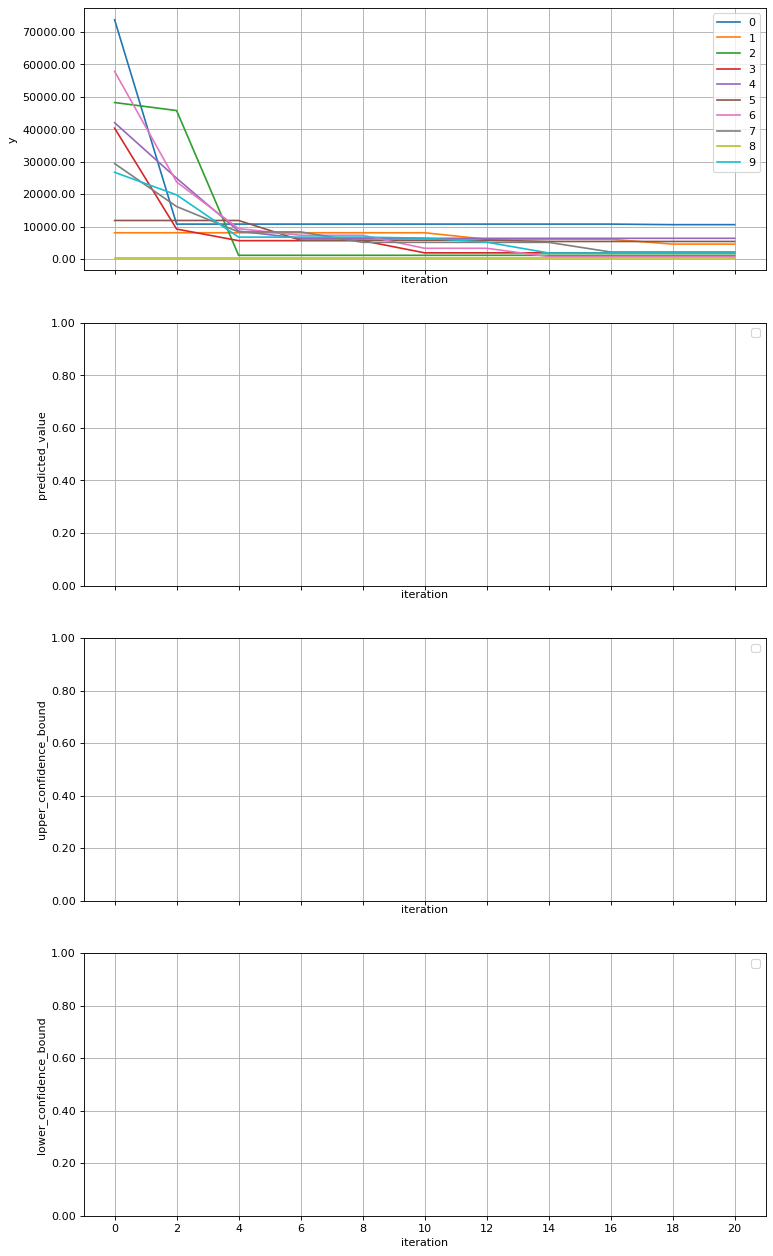

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

fig, axs = plt.subplots(4, figsize=(11, 20), dpi=80, sharex=True)

optimum_definition_names = ['best_observation', 'best_predicted_value', 'ucb_99', 'lcb_99']
optimum_column_names = ['y', 'predicted_value', 'upper_confidence_bound', 'lower_confidence_bound']

for i, (optimum_definition_name, optimum_column_name) in enumerate(zip(optimum_definition_names, optimum_column_names)):
    for j, report in enumerate(evaluation_reports):
        optimum_df = report.optima_over_time[optimum_definition_name].get_dataframe()
        if len(optimum_df.index) > 0:
            axs[i].plot(optimum_df['iteration'], optimum_df[optimum_column_name], label=j)
            axs[i].set_xticks(optimum_df['iteration'])
        
    axs[i].set_ylabel(optimum_column_name)
    axs[i].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    axs[i].grid(True)
    axs[i].set_xlabel('iteration')
    axs[i].legend()  
fig.show()

In [13]:
assert False

AssertionError: 

In [ ]:
import os
os.getpid()

In [ ]:
meta_optimizer.get_all_observations()

In [ ]:
best_observation_config, best_observation

In [ ]:
best_predicted_value_config, best_predicted_value

In [ ]:
# Best observation dataframe
#
best_observation_df = pd.DataFrame([observation.to_dict() for observation in best_observations])
best_observation_df['num_observations'] = best_observation_num_observations
best_observation_df = pd.concat([best_observation_df.drop_duplicates(subset=[meta_optimizer_objective_name], keep='last'), best_observation_df.drop_duplicates(subset=[meta_optimizer_objective_name], keep='first')]).sort_index()
best_observation_df

In [ ]:
best_predicted_value_df = pd.DataFrame([predicted_value.to_dict() for predicted_value in best_predicted_values])
best_predicted_value_df['num_observations'] = predicted_value_num_observations
best_predicted_value_df = pd.concat([best_predicted_value_df.drop_duplicates(subset=['predicted_value'], keep='last'), best_predicted_value_df.drop_duplicates(subset=['predicted_value'], keep='first')]).sort_index()
best_predicted_value_df

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

fig, axs = plt.subplots(1, figsize=(11, 20), dpi=80, sharex=True)

axs.plot(best_observation_df['num_observations'], best_observation_df[meta_optimizer_objective_name], label=meta_optimizer_objective_name)
axs.plot(best_predicted_value_df['num_observations'], best_predicted_value_df['predicted_value'], label='predicted_value')
axs.set_ylabel('y')
axs.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
axs.set_xticks(best_observation_df['num_observations'][::2])
axs.grid(True)
axs.set_xlabel('num_observations')
axs.legend()  
fig.show()

In [ ]:
from mlos.Optimizers.RegressionModels.GoodnessOfFitMetrics import DataSetType

# Let's take a look at goodness of fit data.
#
goodness_of_fit_dataframe = regression_model_fit_state.get_goodness_of_fit_dataframe(data_set_type=DataSetType.TRAIN) # TODO: add support to evaluate GoF on test data

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

gof_df = goodness_of_fit_dataframe
columns_to_plot = [name for name in gof_df.columns.values if name not in ('observation_count', 'prediction_count', 'last_refit_iteration_number')]
num_plots = len(columns_to_plot)
fig, axs = plt.subplots(num_plots, figsize=(11, 20), dpi=80, sharex=True)

for i, column in enumerate(columns_to_plot):
    axs[i].plot(gof_df['last_refit_iteration_number'], gof_df[column], marker='o', label=column)
    axs[i].set_ylabel(column)
    axs[i].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    axs[i].set_xticks(gof_df['last_refit_iteration_number'])
    axs[i].grid(True)
    if i == num_plots - 1:
        axs[i].set_xlabel('last_refit_iteration_number')
        
fig.show()

In [ ]:
global_values.tracer.dump_trace_to_file(r"E:\code\new_mlos\source\Mlos.Python\temp\meta_optimizer.json")

In [ ]:
configs, values = meta_optimizer.get_all_observations()

In [ ]:
import datetime

configs, values = meta_optimizer.get_all_observations()    
merged_observations = pd.concat([configs, values], axis=1)
with open(f"N:\\MLOS\\BayesianOptimizer\\OptimizingOptimizer\\{datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}combined.csv", "w") as out_file:
    merged_observations.to_csv(out_file, line_terminator="\n")

In [ ]:
from IPython.display import display
with pd.option_context('display.max_rows', 2000, 'display.max_columns', 100):
    display(pd.concat([values, configs], axis=1))

In [ ]:
from mlos.Optimizers.OptimumDefinition import OptimumDefinition

predicted_best_config, predicted_optimum = meta_optimizer.optimum(OptimumDefinition.PREDICTED_VALUE_FOR_OBSERVED_CONFIG)
print(predicted_best_config.to_json(indent=2))